# Rainfall Modeling
Playground season 5, episode 3

## Set Environment

In [1]:
# Import packages and show directory files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
import warnings

import os
# Deactivate for local execution
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Deactivate for execution in Kaggle
dirname = os.getcwd()

pd.set_option('display.max_columns', None)
random_state = 42

In [2]:
# Import datasets
train = pd.read_csv(dirname + '/train.csv')
train = train.rename(columns={'temparature': 'temperature'})
test = pd.read_csv(dirname + '/test.csv')
test = test.rename(columns={'temparature': 'temperature'})

target = 'rainfall'

print('Datasets imported correctly')

Datasets imported correctly


In [3]:
# Define Custom Functions
def plot_feature_distribution(data, features):
    n_plots = len(features)
    n_cols = 4
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))
    fig.set_layout_engine('tight')
    axs = axs.ravel()

    for idx, col in enumerate(features):
        axs[idx].hist(data[col], bins=30, color='cornflowerblue')
        axs[idx].set_title(col)
        axs[idx].tick_params(axis='both', labelsize=8)
        axs[idx].tick_params(axis='x', rotation=20)
        axs[idx].yaxis.set_major_formatter(mtick.FuncFormatter(human_format))
        axs[idx].set_ylabel('Samples')

    for idx in range(n_plots, len(axs)):
        axs[idx].set_visible(False)
        
    return fig

def plot_binning_analyzer(data, features, bins=10):
    n_plots = len(features)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 12), sharey=True)
    fig.set_layout_engine('tight')
    axs = axs.ravel()

    for idx, col in enumerate(features):
        data["bin"] = pd.qcut(data[col], q=bins, duplicates='drop')
        data["bin"] = data["bin"].apply(lambda x: f"({round(x.left, 2)}, {round(x.right, 2)}]")
        bin_summary = data.groupby("bin", observed=False)["rainfall"].mean()
        bin_summary.plot(kind='bar', ax=axs[idx], color='teal', alpha=0.7)
        axs[idx].set_title(col)
        axs[idx].set_ylabel('Event rate')
        axs[idx].set_xlabel('')
        axs[idx].yaxis.set_major_formatter(mtick.PercentFormatter(1))

    for idx in range(n_plots, len(axs)):
        axs[idx].set_visible(False)

    data = data.drop(columns=['bin'])

    return fig

def human_format(num, pos):
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.0f}K'
    else:
        return f'{num:.0f}'

def plot_confusion_matrix(model, X_1, y_1, X_2, y_2, data1=None, data2=None, threshold=0.5):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.set_layout_engine('tight')
    fig.patch.set_facecolor('#f2ebe3ff')

    # Get probability predictions
    y_pred_1 = (model.predict_proba(X_1)[:, 1] >= threshold).astype(int)
    y_pred_2 = (model.predict_proba(X_2)[:, 1] >= threshold).astype(int)

    # Compute confusion matrices
    cm1 = confusion_matrix(y_1, y_pred_1)
    cm2 = confusion_matrix(y_2, y_pred_2)

    # Display confusion matrices
    disp1 = ConfusionMatrixDisplay(cm1).plot(cmap='Blues', ax=axs[0])
    disp2 = ConfusionMatrixDisplay(cm2).plot(cmap='Blues', ax=axs[1])

    # Remove colorbars
    for disp in [disp1, disp2]:
        for img in disp.ax_.get_images():
            img.colorbar.remove()

    # Add titles
    axs[0].set_title(f'Confusion Matrix - {data1}')
    axs[1].set_title(f'Confusion Matrix - {data2}')
    
    return fig

print('Custom functions defined')

Custom functions defined


## Basic EDA
As every other dataset, I will first explore data structure and quality, in case anything needs to be solved before the modeling phase.

In [4]:
# Train data sample
train.sample(5)

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1274,1274,180,1007.6,32.2,29.2,26.2,25.9,86.0,82.0,1.2,180.0,14.6,1
571,571,207,1009.5,32.0,29.1,26.4,25.1,70.0,43.0,10.3,180.0,13.0,1
1255,1255,161,1009.3,31.7,29.4,27.6,25.6,84.0,86.0,1.6,190.0,21.6,1
1939,1939,115,1011.4,25.2,23.1,21.0,20.9,79.0,79.0,3.1,40.0,26.5,0
579,579,215,1007.5,33.4,30.7,27.3,26.1,79.0,83.0,2.8,220.0,23.9,1


In [5]:
# Define relevant columns
avoid_cols = ['id', 'day', 'rainfall']
base_features = [col for col in train.columns if col not in avoid_cols]
base_features

['pressure',
 'maxtemp',
 'temperature',
 'mintemp',
 'dewpoint',
 'humidity',
 'cloud',
 'sunshine',
 'winddirection',
 'windspeed']

In [6]:
# Data shape
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (2190, 13)
Test shape:  (730, 12)


In [7]:
# Descriptive statistics
train.describe()

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [8]:
# Check for missing values
train.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

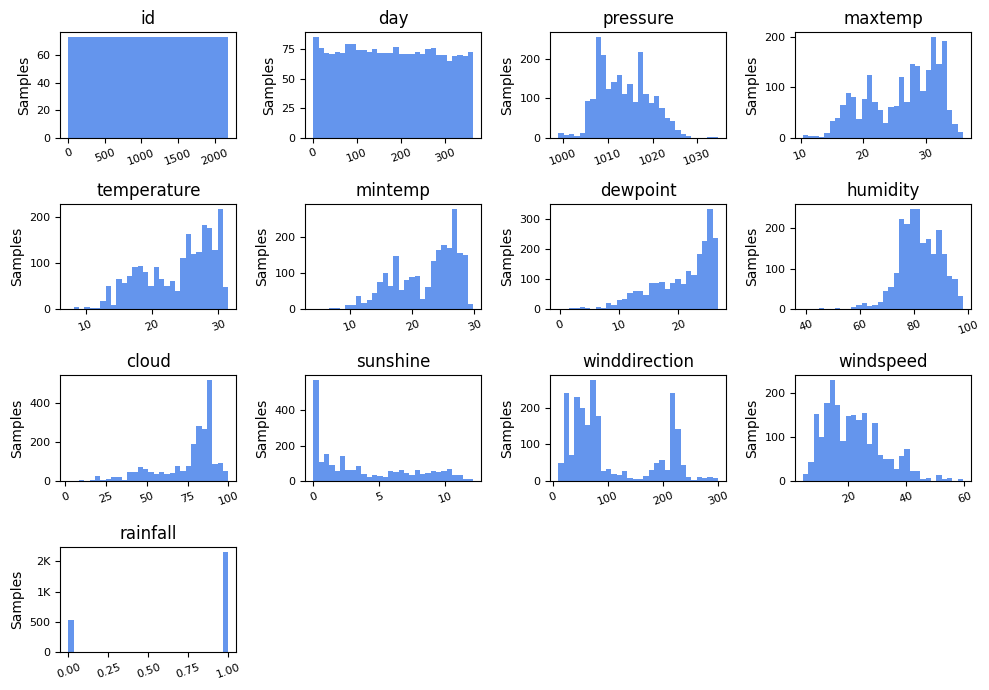

In [9]:
# Assess numerical columns distributions
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
numerical_plots = plot_feature_distribution(train, numerical_columns)

There are interesting insights from these features. 
* `pressure` and `windspeed` seem to have a normal-like distribution.
* `maxtemp`, `temperature` and `mintemp` all are slightly skewed to the left
* `dewpoint`, `humidity` and `cloud` are all very skewed to the left
* `sunshine` is very skewed to the right
* `winddirection` seems to be bimodal (there are to clear peaks)

_Note: depending on the algorithm, the skewed features should be transformed and scaled to improve the model performance_

In [10]:
# There are no categorical columns (beside the rainfall label)
categorical_columns = train.select_dtypes(include=['object']).columns
print('Number of categorical columns: ', len(categorical_columns))

Number of categorical columns:  0


In [11]:
# Label distribution (%)
train[target].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

In [12]:
# Label distribution (#)
train[target].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

The dataset is imbalanced, which is always necessary to know. In fact, this should impact the way the target is modeled.

Regarding basic relationships between the target variable and the features, it is not a good approach to calculate correlations, since the target is a binary variable. Other approaches should be better, like assessing feature importance in a tree model, for example. 

In this case, I will try with a binning analyzer, which basically groups the feature in bins and then calculates the amount of positive labels within each bin. The idea is to show if there are features that show a clear positive or negative relationship.

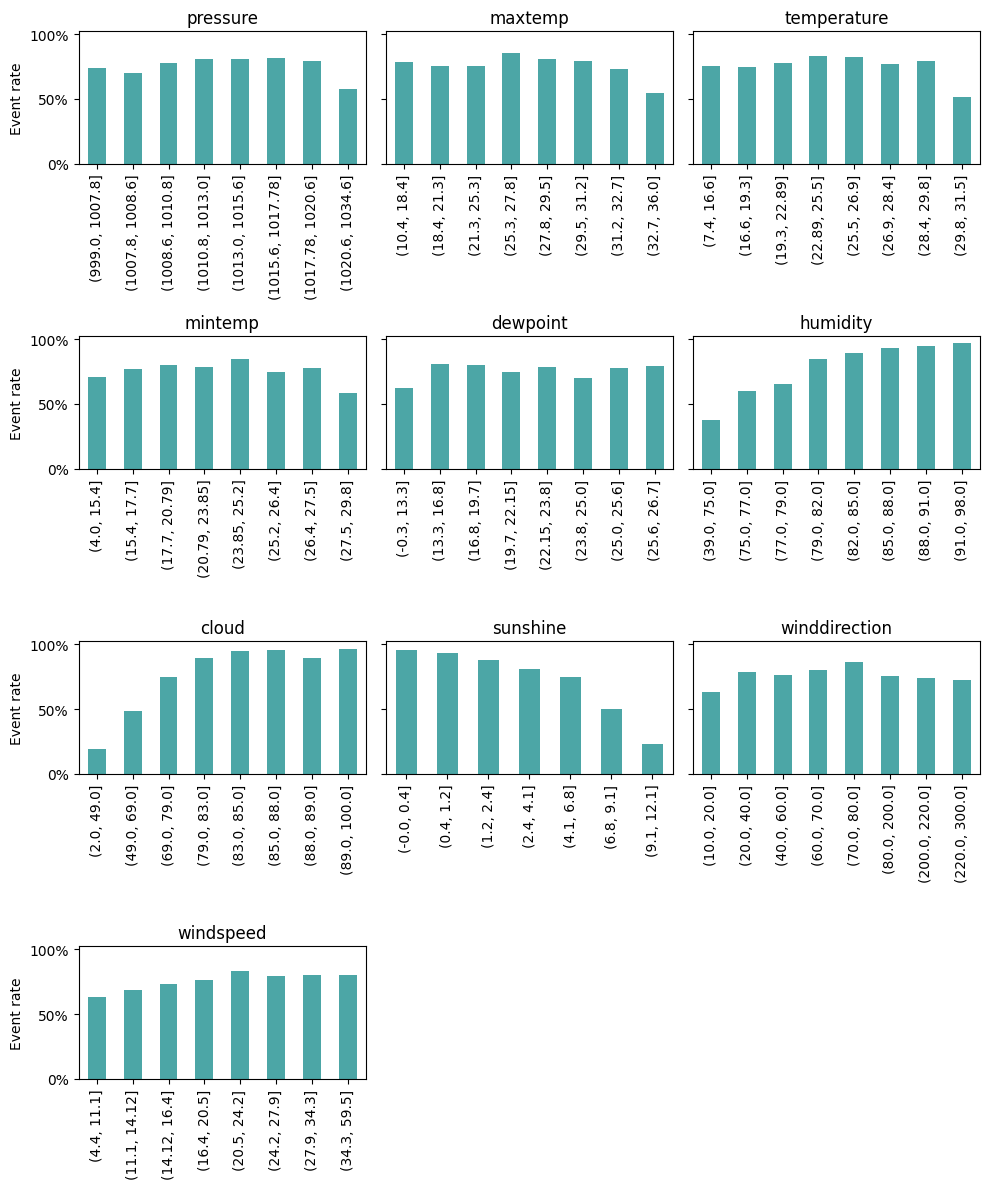

In [13]:
# Binning Analyzer
rainfall_binning = plot_binning_analyzer(train, base_features, 8)

The binning analysis above shows that both `humidity` and `cloud` have a positive relation with the event rate, while `sunshine` shows a negative relation. During modeling I will have to figure out if it's better to add them as labels (e.g. `cloud` < 70) or as continious features.

The rest don't show a clear relation so far, but still they could be added to a model to improve its performance.

## Feature Engineering

In [14]:
# As mentioned before, some features will probably have to be transformed and scaled
skewed_features = ['maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity', 'sunshine', 'cloud']

for feature in skewed_features:
    # Train set
    scaler = StandardScaler()
    scaled_feature_name = f'{feature}_scaled'
    train[scaled_feature_name] = np.log1p(train[feature])
    train[scaled_feature_name] = scaler.fit_transform(train[scaled_feature_name].values.reshape(-1, 1))
    
    # Test set
    test[scaled_feature_name] = np.log1p(test[feature])
    test[scaled_feature_name] = scaler.transform(test[scaled_feature_name].values.reshape(-1, 1))

print('Features scaled and log transformed')

Features scaled and log transformed


Now there is a new column per each skewed feature. This should help in models that non-tree models.

In [15]:
# Additional features
train['windspeed_squared'] = train['windspeed'] ** 2
train['temperature_difference'] = train['maxtemp'] - train['mintemp']

## Sampling

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=[target]), train[target], test_size=0.3, stratify=train[target], random_state=42)

print('Train set: ', X_train.shape)
print('Validation set: ', X_val.shape)
print('Train labels: ', y_train.shape)
print('Validation labels: ', y_val.shape)

Train set:  (1533, 22)
Validation set:  (657, 22)
Train labels:  (1533,)
Validation labels:  (657,)


## Model

In [17]:
# Model: LightGBM
features = [
    'humidity',
    'cloud',
    'sunshine',
    'temperature',
    'windspeed'
    #'pressure'
    #'winddirection',
]

base_params = {
    "boosting": "dart",
    "learning_rate": 0.1,
    "max_bin": 200,
    "max_depth": 5,
    "num_leaves": 40,
    #"is_unbalance": True,
    "min_data_in_leaf": 200,
    "min_gain_to_split": 2.5,
    "reg_alpha": 0.1,
    #"reg_lambda": 0.1,
    "objective": "binary",
    "seed": random_state,
    "metric": "auc",
    #"feature_fraction": 0.8,
    "verbose": -1,
}

training_rounds = 250
dtrain = lgbm.Dataset(data=X_train[features], label=y_train)
dval = lgbm.Dataset(data=X_val[features], label=y_val, reference=dtrain)

lgbm_base_model = lgbm.train(
    params=base_params,
    train_set=dtrain,
    num_boost_round=training_rounds,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
)

y_val_pred_proba = lgbm_base_model.predict(X_val[features])
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Check model performance
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print('Validation Accuracy: ', val_accuracy)
print('Validation Precision: ', val_precision)
print('Validation Recall: ', val_recall)
print('Validation AUC ', val_roc_auc)

Validation Accuracy:  0.878234398782344
Validation Precision:  0.8922495274102079
Validation Recall:  0.9535353535353536
Validation AUC  0.894307270233196


In [18]:
# Logistic regression
features = [
    'cloud_scaled',
    'humidity_scaled',
    'sunshine_scaled',
    #'temperature_difference',
    #'windspeed_squared'
    #'temperature_scaled',
    #'windspeed'
    #'pressure'
    #'winddirection',
]

lr = LogisticRegression(
    solver='lbfgs',
    class_weight='balanced',
    random_state=random_state, 
    max_iter=500
    #n_jobs=-1
)
lr.fit(X_train[features], y_train)

y_val_pred_proba = lr.predict_proba(X_val[features])[:, 1]
y_val_pred = lr.predict(X_val[features])

# Check model performance
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print('Validation Accuracy: ', val_accuracy)
print('Validation Precision: ', val_precision)
print('Validation Recall: ', val_recall)
print('Validation AUC ', val_roc_auc)

Validation Accuracy:  0.8493150684931506
Validation Precision:  0.9159663865546218
Validation Recall:  0.8808080808080808
Validation AUC  0.8923868312757203


In [19]:
# Random Forest Classifier
features = [
    'cloud',
    'humidity',
    'sunshine',
    'temperature_difference',
    #'windspeed_squared'
    #'temperature_scaled',
    #'windspeed',
    #'pressure',
    #'winddirection',
]

rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf.fit(X_train[features], y_train)

y_val_pred_proba = rf.predict_proba(X_val[features])[:, 1]
y_val_pred = rf.predict(X_val[features])

# Check model performance
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print('Validation Accuracy: ', val_accuracy)
print('Validation Precision: ', val_precision)
print('Validation Recall: ', val_recall)
print('Validation AUC ', val_roc_auc)

Validation Accuracy:  0.8569254185692542
Validation Precision:  0.8775894538606404
Validation Recall:  0.9414141414141414
Validation AUC  0.8621336825040529


In [ ]:
# XGBoost + GridSearchCV
param_grid = {
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, 4],
    'min_child_weight': [1, 10],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.01],
    'eval_metric': ['auc'],
    #'reg_alpha': [0.1],
    #'reg_lambda': [0.1]
}

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

xgb = XGBClassifier(
    random_state=random_state
)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=kf,
    scoring='roc_auc',
    verbose=1
)

grid_search_xgb.fit(
    X_train[features], y_train,
    eval_set=[(X_val[features], y_val)],
    #early_stopping_rounds=10,
    verbose=False
)

y_val_pred_proba = grid_search_xgb.predict_proba(X_val[features])[:, 1]
y_val_pred = grid_search_xgb.predict(X_val[features])

# Check model performance
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print('Validation Accuracy: ', val_accuracy)
print('Validation Precision: ', val_precision)
print('Validation Recall: ', val_recall)
print('Validation AUC ', val_roc_auc)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Validation Accuracy:  0.8264840182648402
Validation Precision:  0.8245315161839863
Validation Recall:  0.9777777777777777
Validation AUC  0.890329218106996


## Final Output

Seems like LightGBM is performing well on this dataset. For these initial versions I will use this model to predict on the test dataset. 

_Note: I will later try adding the original dataset, since the instructions say that this could improve the performance of the models._

In [29]:
features = [
    'humidity',
    'cloud',
    'sunshine',
    'temperature',
    'windspeed'
]
y_test_pred = lgbm_base_model.predict(test[features])
test['rainfall'] = y_test_pred
test[['id', 'rainfall']].to_csv('submission.csv', index=False)